# ***Tarea 4. KNN***
### Luis Eduardo Jiménez del Muro - 21/02/2025
---

## Paqueterías y funciones

In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings('ignore')

In [2]:
## Crea una función de calibracion
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    r2 = r2_score(y_pred=predicciones, y_true=y)
    
    # Gráfica
    plt.figure(figsize=(8,6))
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', color='red', lw=2)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='cadetblue', ms=5, lw=2)
    plt.title(f'Calibración del modelo \n\n$R2={r2:.4f}$')
    plt.grid(alpha=0.5)
    plt.legend()
    plt.xlabel('Predicción')
    plt.ylabel('Real')

## Preparación de los datos

In [3]:
df = pd.read_csv('day.csv')
df = df.drop(columns=['casual', 'registered', 'instant', 'yr', 'mnth', 'dteday'])

categoricas = ['season', 'weekday', 'weathersit']
df = pd.get_dummies(df, columns=categoricas)
df.head()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,0,0,0.344167,0.363625,0.805833,0.160446,985,True,False,False,...,False,False,False,False,False,False,True,False,True,False
1,0,0,0.363478,0.353739,0.696087,0.248539,801,True,False,False,...,True,False,False,False,False,False,False,False,True,False
2,0,1,0.196364,0.189405,0.437273,0.248309,1349,True,False,False,...,False,True,False,False,False,False,False,True,False,False
3,0,1,0.200000,0.212122,0.590435,0.160296,1562,True,False,False,...,False,False,True,False,False,False,False,True,False,False
4,0,1,0.226957,0.229270,0.436957,0.186900,1600,True,False,False,...,False,False,False,True,False,False,False,True,False,False


## Aplicar algoritmo KNN

In [4]:
X = df.copy().drop('cnt', axis=1) 
y = df['cnt']

# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

nn = []
r2 = []
r2_train = []
for i in range(1, 50):
    model = KNeighborsRegressor(n_neighbors=i).fit(X_train_scaled, y_train)
    predicciones = model.predict(X_test_scaled)
    r2.append(r2_score(y_true=y_test, y_pred=predicciones))
    nn.append(i)
    predicciones_train = model.predict(X_train_scaled)
    r2_train.append(r2_score(y_true=y_train, y_pred=predicciones_train))
    
resultados = pd.DataFrame({'nn':nn, 'r2': r2, 'r2_train': r2_train})

## Graficar los resultados

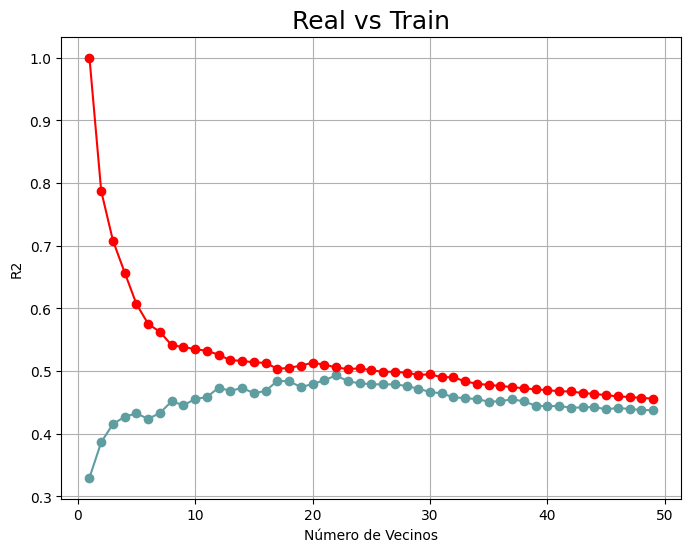

In [5]:
plt.figure(figsize=(8,6))
plt.title('Real vs Train', fontsize=18)
plt.plot(resultados.nn, resultados.r2, label='real', color='cadetblue', marker='o')
plt.plot(resultados.nn, resultados.r2_train, label='train', color='red', marker='o')
plt.xlabel('Número de Vecinos')
plt.ylabel('R2')
plt.grid()

## Elegir el óptimo

In [6]:
maxr2 = resultados[resultados['r2'] == resultados.max()['r2']][['nn', 'r2']]
maxr2

,nn,r2
21,22,0.493093


## Calibración del modelo

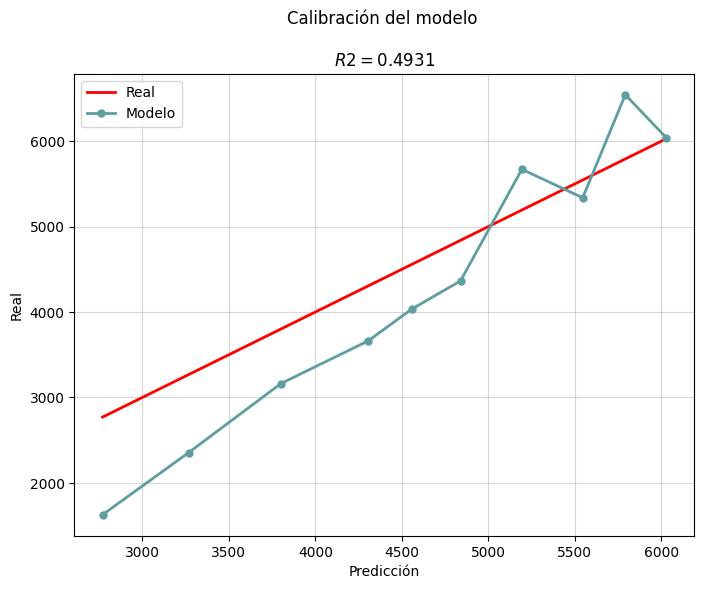

In [7]:
model = KNeighborsRegressor(n_neighbors=int(maxr2['nn'])).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
calibracion(predicciones, y_test, 10)

## Conclusiones

* Se obtuvo que el número de vecinos que maximiza el R2 es de 22 vecinos.
* A pesar de ser el máximo R2, tan solo se obtuvo un 0.49
* A comparación de los modelos realizados en tareas pasadas, este modelo tuvo un desempeño peor a otros modelos como regresiones lineales y polinómicas.
* A pesar de que los resultados que se obtuvieron no fueron los mejores, fueron buenos para ser un modelo sencillo solo realiza promedios con los datos cercanos.
* A medida de que el número de vecinos sobrepasa el óptimo de 22, el R2 comienza a disminuir, lo que indica que está habiendo overfitting.